In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD
import SiameseNeuralNetwork as SNN
import SimpleNeuralNetwork as SimpNN
from matplotlib import pyplot as plt
from pubchempy import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import PeriodicTable as PT
import re

In [2]:
# Load the dataset. Clean it up by removing missing molecule features. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature
molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp", "rotatable_bond_count"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

molecule_features.heavy_atom_count = np.log(molecule_features.heavy_atom_count)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

xe = torch.tensor(np.array(eutectic_compilation.xe).astype(float) / 100.0)
eutectic_compilation.xe = xe

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
# Obtain the indices of train, val, and test datasets in molecule_features
trainindices = np.array([]).astype(int)
valindices = np.array([]).astype(int)
testindices = np.array([]).astype(int)

for i in range(len(train_ec)):
    line = train_ec.iloc[i]
    
    m1 = line[0]
    m2 = line[1]
    
    trainindices = np.append(trainindices, np.where(molecule_features.mol == m1))
    trainindices = np.append(trainindices, np.where(molecule_features.mol == m2))

for i in range(len(val_ec)):
    line = val_ec.iloc[i]
    
    m1 = line[0]
    m2 = line[1]
    
    valindices = np.append(valindices, np.where(molecule_features.mol == m1))
    valindices = np.append(valindices, np.where(molecule_features.mol == m2))
    
for i in range(len(test_ec)):
    line = test_ec.iloc[i]
    
    m1 = line[0]
    m2 = line[1]
    
    testindices = np.append(testindices, np.where(molecule_features.mol == m1))
    testindices = np.append(testindices, np.where(molecule_features.mol == m2))
    
trainindices = np.unique(trainindices)
valindices = np.unique(valindices)
testindices = np.unique(testindices)

In [6]:
address = ['n1', 'c1', 'n2', 'c2', 'n3', 'c3', 'n4', 'c4', 'n5', 'c5']
for i in range(len(address)):
    molecule_features[address[i]] = np.zeros((len(molecule_features)))

In [7]:
# Add 8 more features using PubChemPy and test with those. In notepad file from meeting. 
importlib.reload(PT)
pt = PT.PT()

for m in range(len(molecule_features.mol)):
    split = re.findall('[A-Z][^A-Z]*', re.sub('[^\w]', "", molecule_features.mol[m])) 
    # split the molecule by elements (with count of each element) and remove any symbols (only letters and numbers)
    
    nummolecules = len(split) # obtain number of elements after split
    atomic_nums = np.array([])
    atomic_counts = np.array([])
    masses = np.array([])
    
    for s in range(len(split)):
        formula = re.sub('[^A-Za-z]', "", split[s]) # obtain each element alone
        count = re.sub('[A-Za-z]', "", split[s]) # obtain the count of each element alone
        
        if count == "":
            count = "1"
        count = int(count) # convert the string to int
        
        # Obtain the atomic number and mass by using the formula from periodic table. 
        data = pt.get(formula)
        atomic_nums = np.append(atomic_nums, data[0])
        masses = np.append(masses, data[1])
        atomic_counts = np.append(atomic_counts, count)
        
        # print(formula, count, type(formula), type(count)) # to see what prints
        
    # Sort in ascending order, the atomic numbers and counts by mass of atom
    atomic_nums = [atomic_nums for _, atomic_nums in sorted(zip(masses, atomic_nums))]
    atomic_counts = [atomic_counts for _, atomic_counts in sorted(zip(masses, atomic_counts))]
    
    # Add into the molecule_features dataframe in correct order
    i = 0
    j = 0
    for i in range(len(atomic_nums)):
        molecule_features[molecule_features.columns[j+5]][m] = atomic_nums[i]
        molecule_features[molecule_features.columns[j+6]][m] = atomic_counts[i]
        j += 2

C:\Users\arjun\AppData\Local\Temp\ipykernel_19096\68809024.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molecule_features[molecule_features.columns[j+5]][m] = atomic_nums[i]
C:\Users\arjun\AppData\Local\Temp\ipykernel_19096\68809024.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molecule_features[molecule_features.columns[j+6]][m] = atomic_counts[i]


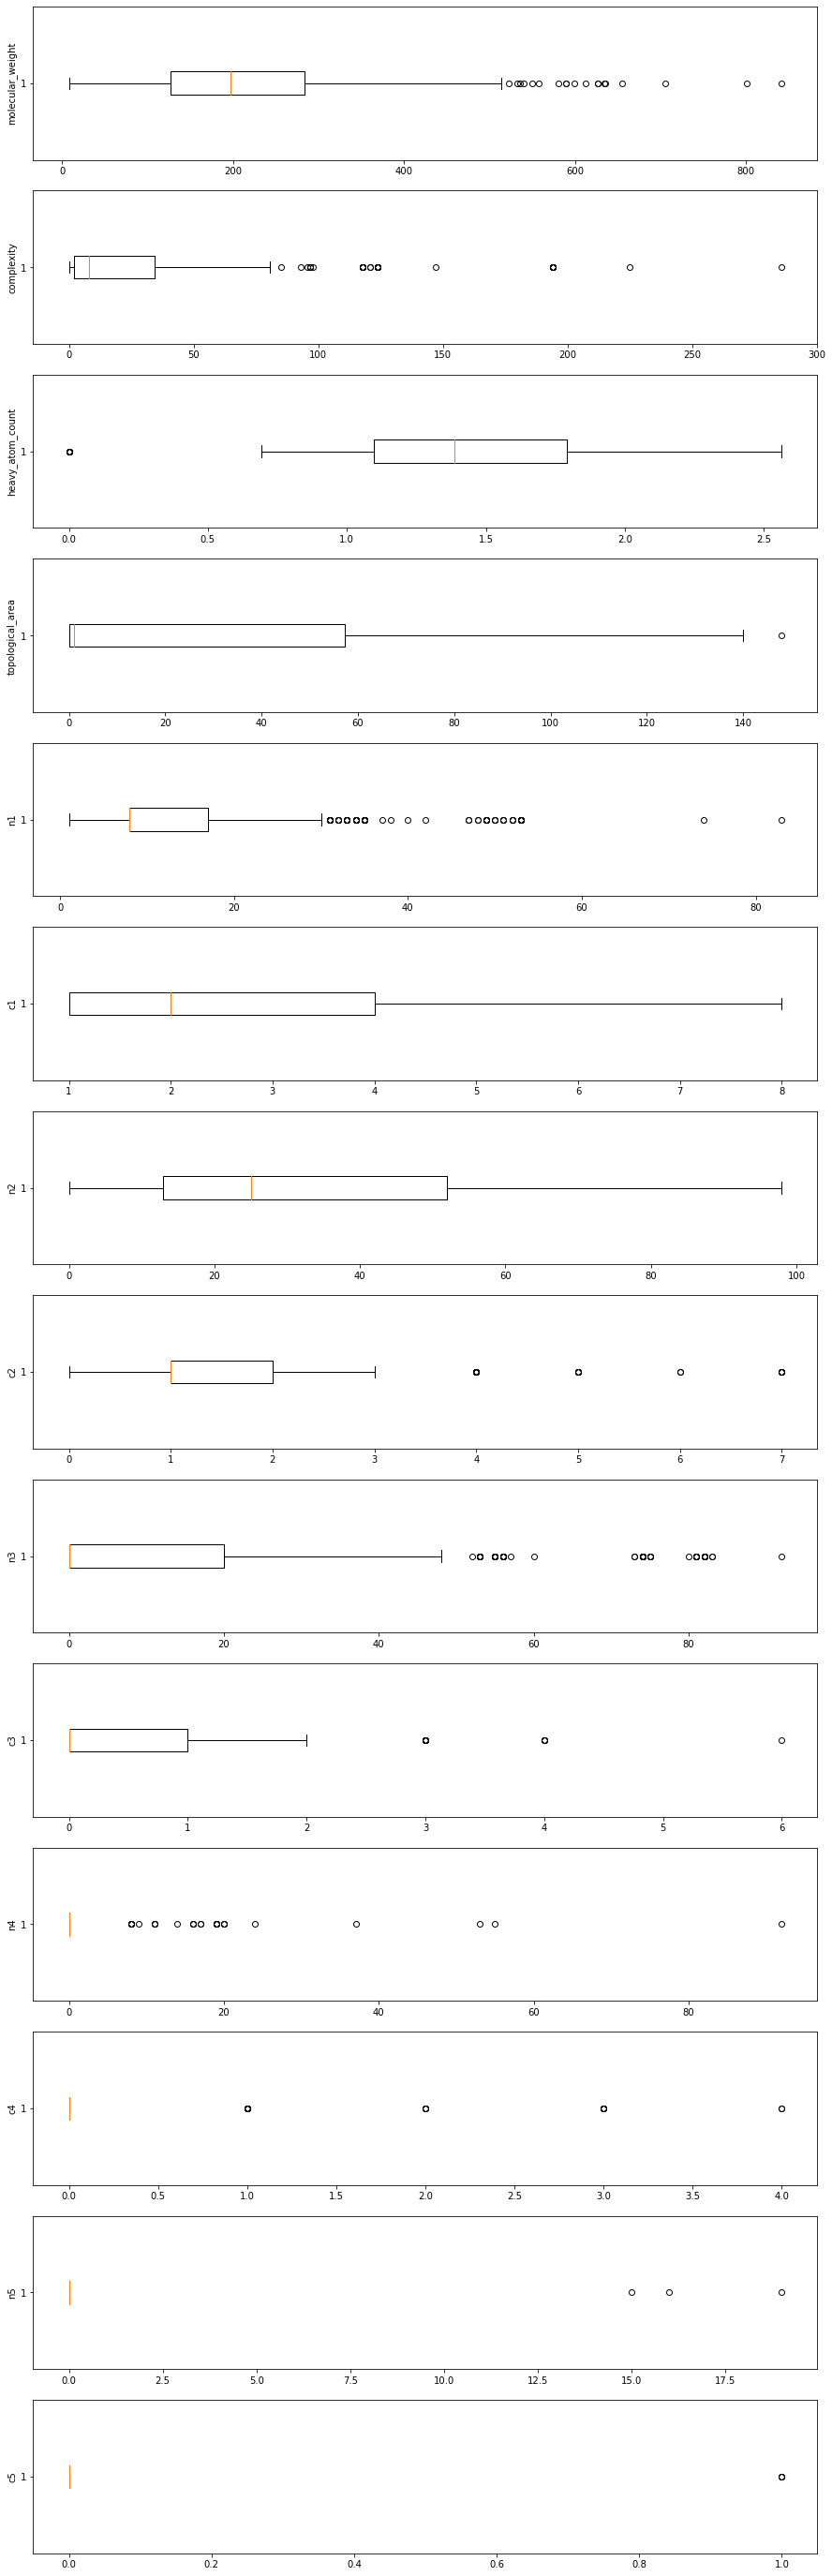

In [8]:
fig0, axes = plt.subplots(len(molecule_features.columns) - 1, 1)
fig0.set_figheight(50)
fig0.set_figwidth(15)

for i in range(len(molecule_features.columns) - 1):
    axes[i].boxplot(molecule_features[molecule_features.columns[i+1]], vert=False)
    axes[i].set(ylabel=molecule_features.columns[i+1])

fig0.savefig('D:\\Research\\UConn_ML\\Plots\\Feature_Box_Plots_8_11_22.png')

In [9]:
# Z-Score Scaler transformation on molecule features
scaler = StandardScaler()
molecule_features.iloc[trainindices, 1:] = scaler.fit_transform(molecule_features.iloc[trainindices, 1:])
molecule_features.iloc[valindices, 1:] = scaler.transform(molecule_features.iloc[valindices, 1:])
molecule_features.iloc[testindices, 1:] = scaler.transform(molecule_features.iloc[testindices, 1:])

In [10]:
molecule_features

,mol,molecular_weight,complexity,heavy_atom_count,topological_area,n1,c1,n2,c2,n3,c3,n4,c4,n5,c5
0,BaO,-1.740959,-0.673136,-5.568887,-0.710465,-1.182055,-2.264638,-1.370955,-2.066041,-0.641139,-1.494539,-0.169962,-0.619744,-0.114338,-1.059718
1,CrCl3,-1.750475,-0.675126,-8.453642,-0.723357,-1.236112,-2.557707,-1.468039,-3.498138,-0.642384,-2.531588,-0.174534,-1.863314,-0.174686,-18.864752
2,PBr5,1.649091,0.358858,0.747890,-0.703906,0.112728,-0.996839,0.043070,3.255429,-0.613503,-0.664443,-0.144279,-0.165745,-0.056135,-0.056523
3,WCl5,1.103327,0.358858,0.747890,-0.703906,0.280088,1.542775,1.660958,-0.567683,-0.613503,-0.664443,-0.144279,-0.165745,-0.056135,-0.056523
4,HgI2,-1.722335,-0.672537,-3.996284,-0.722848,-0.866950,-1.861536,-1.329652,-2.066041,-0.641139,-1.494539,-0.169962,-0.619744,-0.114338,-1.059718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,PBr3,0.392237,-0.437680,-0.050631,-0.703906,0.112728,-0.996839,0.043070,1.343873,-0.613503,-0.664443,-0.144279,-0.165745,-0.056135,-0.056523
673,PbSiO3,0.489057,-0.142058,0.388827,0.996774,-0.473032,0.272968,-0.828101,-0.567683,3.080283,0.584869,-0.144279,-0.165745,-0.056135,-0.056523
674,LiI,-1.742161,-0.673136,-5.568887,-0.722848,-1.217067,-2.264638,-1.376118,-2.066041,-0.641139,-1.494539,-0.169962,-0.619744,-0.114338,-1.059718
675,EuF3,-1.737518,-0.668640,-2.880505,-0.722848,-1.175052,-1.458434,-1.358908,-2.066041,-0.641139,-1.494539,-0.169962,-0.619744,-0.114338,-1.059718


In [11]:
eutectic_compilation

,molA,molB,xe,Te
0,BF3,N2O,0.766,-138.0
1,BF3,SO2,0.952,-128.6
2,BCl3,GeCl4,0.760,-116.0
3,BCl3,PCl3,0.940,-110.0
4,BCl3,PCl3,0.200,-99.0
...,...,...,...,...
4463,Sc2O3,ZrO2,0.522,2450.0
4464,UO2,ZrO2,0.475,2550.0
4465,UO2,ZrO2,0.500,2550.0
4466,UN,W,1.000,2700.0


In [12]:
train_ec

,molA,molB,xe,Te
3373,NaF,Na2SO4,0.300,746.0
3439,LiF,SrF2,0.800,761.0
3890,Cs2SO4,Rb2SO4,0.650,948.0
3580,CrCl3,RbCl,0.499,803.0
2381,Li2SO4,Na2SO4,0.630,584.0
...,...,...,...,...
3628,MgCl2,Na3AlF6,0.280,820.0
4377,Al2O3,MgO,0.850,2000.0
863,CsNO3,LiC2H3O2,0.100,245.0
1870,EuCl3,KCl,0.150,490.0


In [13]:
val_ec

,molA,molB,xe,Te
3492,KF,KPO3,0.620,776.0
3557,CsF,ScF3,0.675,796.0
3026,KF,K2CO3,0.470,688.0
3598,CaF2,NaF,0.325,810.0
2813,BaCl2,NaCl,0.399,654.0
...,...,...,...,...
1526,Rb2TeO3,TeO2,0.220,412.0
4004,GdF3,NaF,0.680,1058.0
2089,Cs2CrO4,Na2CrO4,0.380,530.0
3361,LiF,YF3,0.820,744.0


In [14]:
test_ec

,molA,molB,xe,Te
44,TiCl4,WCl6,1.000,-23.0
73,ICl,NbCl5,0.920,21.0
88,XeF2,XeF6,0.050,30.0
114,AlBr3,InBr3,0.900,60.0
128,GaCl3,KCl,0.825,70.0
...,...,...,...,...
4373,Cr2O3,Sm2O3,0.200,1980.0
4376,Al2O3,MgO,0.350,2000.0
4416,La2O3,ZrO2,0.600,2100.0
4441,SiO2,ZrO2,0.420,2220.0


In [15]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [16]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [17]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 14
batchsize = 30
max_epochs = 15
lrbase = 1e-8
lrmax = 1e-3

# For xe
overfit_bound = 0.25
# For Te
# overfit_bound = 0.3

train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# The best constant value to use for MAE is the median of the dataset
# MAE tells us how much + or - pred is from truth on average
train_median = torch.median(torch.tensor(np.array(train_ec["xe"]).astype(float)))
# train_median = torch.median(torch.tensor(np.array(train_ec["Te"]).astype(float)))

train_param = "xe"

In [18]:
importlib.reload(MR)
importlib.reload(SNN)
importlib.reload(SimpNN)
modelrunner = MR.MR(starting_features, batchsize, max_epochs, lrbase, lrmax,
                    train_dset, val_dset, test_dset, train_median, train_param)

In [19]:
trloss, trbase, vloss, vbase = modelrunner.train_and_validate('siam')

Epoch 1 | Train Loss: 0.219328 | Train Baseline: 0.218773 | Val Loss: 0.221079 | Val Baseline: 0.219483
Epoch 2 | Train Loss: 0.219346 | Train Baseline: 0.218773 | Val Loss: 0.221059 | Val Baseline: 0.219483
Epoch 3 | Train Loss: 0.219316 | Train Baseline: 0.218773 | Val Loss: 0.221024 | Val Baseline: 0.219483
Epoch 4 | Train Loss: 0.219498 | Train Baseline: 0.218773 | Val Loss: 0.220972 | Val Baseline: 0.219483
Epoch 5 | Train Loss: 0.219165 | Train Baseline: 0.218773 | Val Loss: 0.220931 | Val Baseline: 0.219483
Epoch 6 | Train Loss: 0.219484 | Train Baseline: 0.218773 | Val Loss: 0.220886 | Val Baseline: 0.219483
Epoch 7 | Train Loss: 0.219204 | Train Baseline: 0.218773 | Val Loss: 0.220817 | Val Baseline: 0.219483
Epoch 8 | Train Loss: 0.219569 | Train Baseline: 0.218773 | Val Loss: 0.220776 | Val Baseline: 0.219483
Epoch 9 | Train Loss: 0.219675 | Train Baseline: 0.218773 | Val Loss: 0.220697 | Val Baseline: 0.219483
Epoch 10 | Train Loss: 0.219499 | Train Baseline: 0.218773 | Val

In [20]:
outputs, invouts, truths, testloss, r2 = modelrunner.test()

Test Loss: 0.223 | Test Baseline: 0.223 | R^2: -0.025



In [21]:
simptrloss, simptrbase, simpvloss, simpvbase = modelrunner.train_and_validate('simp', overfit_bound)

Epoch 1 | Train Loss: 0.320105 | Train Baseline: 0.218773 | Val Loss: 0.296054 | Val Baseline: 0.219483
Epoch 2 | Train Loss: 0.302012 | Train Baseline: 0.218773 | Val Loss: 0.277364 | Val Baseline: 0.219483
Epoch 3 | Train Loss: 0.277543 | Train Baseline: 0.218773 | Val Loss: 0.253713 | Val Baseline: 0.219483
Epoch 4 | Train Loss: 0.247926 | Train Baseline: 0.218773 | Val Loss: 0.234518 | Val Baseline: 0.219483
Early Stop. Validation loss under overfitting threshold.


In [22]:
simpoutputs, simpinvouts, simptruths, simptestloss, simpr2 = modelrunner.test()

Test Loss: 0.235 | Test Baseline: 0.223 | R^2: -0.206



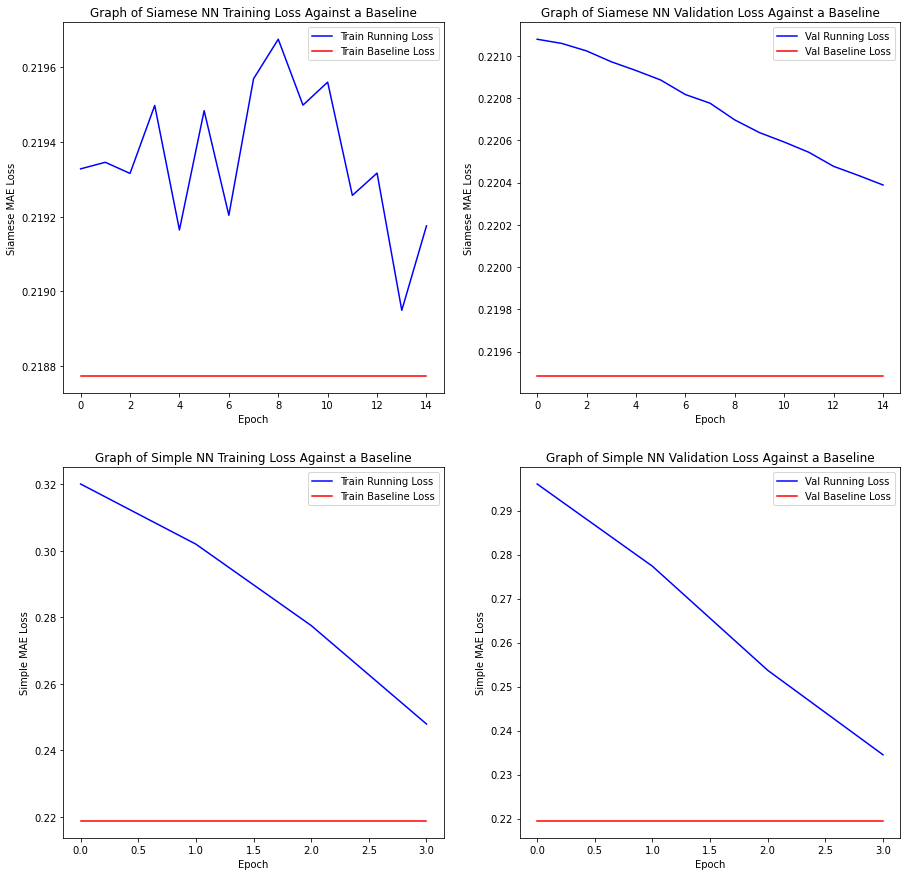

In [23]:
l1 = len(trloss)
l2 = len(simptrloss)
x1 = np.arange(l1)
x2 = np.arange(l2)

lossfig, axes = plt.subplots(2, 2)
lossfig.set_figheight(15)
lossfig.set_figwidth(15)
            
axes[0, 0].plot(x1, trloss[0:l1], label="Train Running Loss", c="blue")
axes[0, 0].plot(x1, trbase[0:l1], label="Train Baseline Loss", c="red")
axes[0, 0].set_title("Graph of Siamese NN Training Loss Against a Baseline")
axes[0, 0].set(xlabel="Epoch", ylabel="Siamese MAE Loss")
axes[0, 0].legend(loc="upper right")

axes[0, 1].plot(x1, vloss[0:l1], label="Val Running Loss", c="blue")
axes[0, 1].plot(x1, vbase[0:l1], label="Val Baseline Loss", c="red")
axes[0, 1].set_title("Graph of Siamese NN Validation Loss Against a Baseline")
axes[0, 1].set(xlabel="Epoch", ylabel="Siamese MAE Loss")
axes[0, 1].legend(loc="upper right")

axes[1, 0].plot(x2, simptrloss[0:l2], label="Train Running Loss", c="blue")
axes[1, 0].plot(x2, simptrbase[0:l2], label="Train Baseline Loss", c="red")
axes[1, 0].set_title("Graph of Simple NN Training Loss Against a Baseline")
axes[1, 0].set(xlabel="Epoch", ylabel="Simple MAE Loss")
axes[1, 0].legend(loc="upper right")

axes[1, 1].plot(x2, simpvloss[0:l2], label="Val Running Loss", c="blue")
axes[1, 1].plot(x2, simpvbase[0:l2], label="Val Baseline Loss", c="red")
axes[1, 1].set_title("Graph of Simple NN Validation Loss Against a Baseline")
axes[1, 1].set(xlabel="Epoch", ylabel="Simple MAE Loss")
axes[1, 1].legend(loc="upper right")

plt.show()

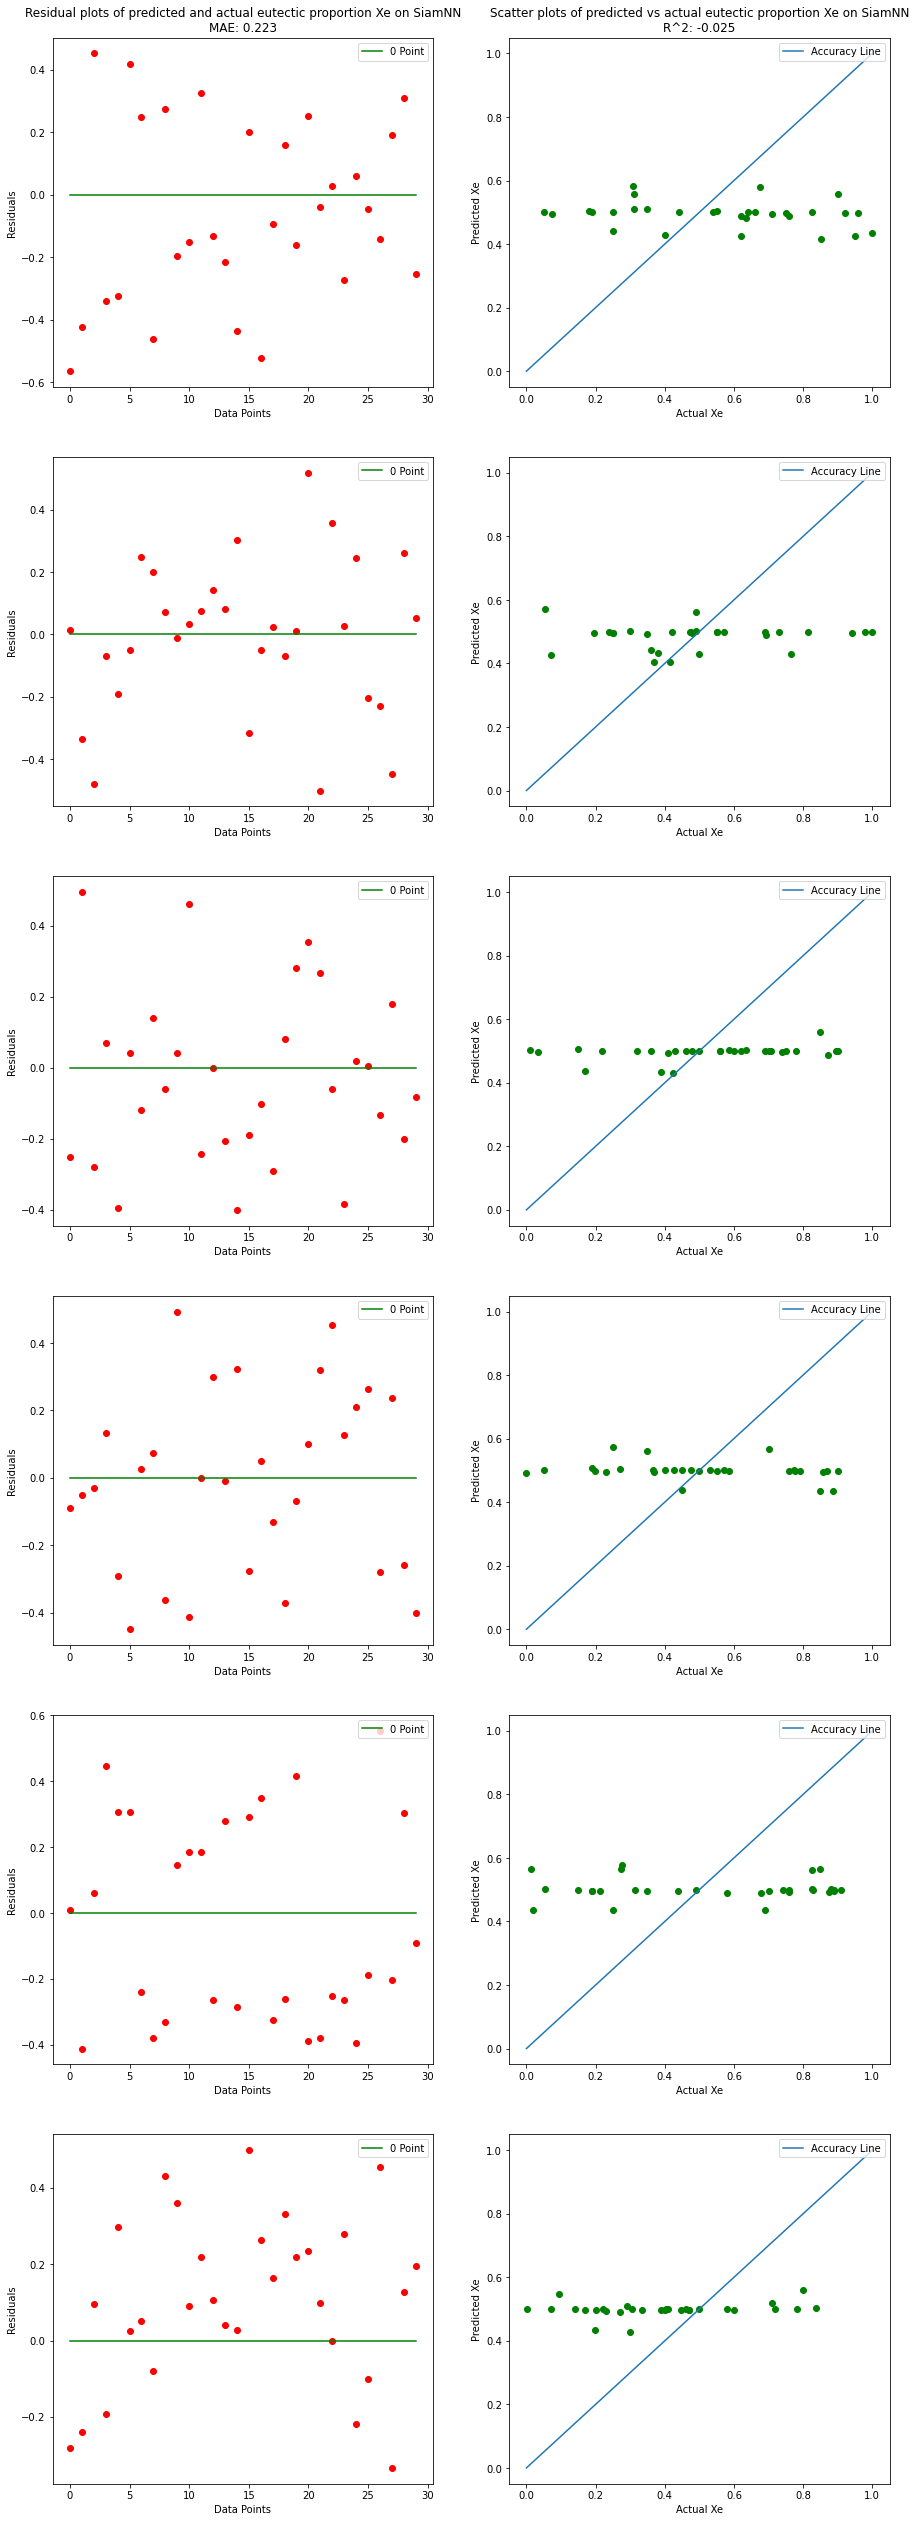

In [24]:
l = batchsize
numplots = int(len(outputs) / l)
siamfig, axes = plt.subplots(numplots, 2)
siamfig.set_figheight(45)
siamfig.set_figwidth(15)

pred = 0
succ = 1
x = np.arange(l)
acc = np.linspace(0, 1, 10)
mae = np.round(testloss, 3)
        
for row in range(numplots):        
    axes[row, 0].scatter(x, outputs[pred*l:succ*l] - truths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(truths[pred*l:succ*l], outputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(acc, acc, label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")
            
    pred += 1
    succ += 1

r2 = np.round(r2_score(truths, outputs), 3)

if train_param == "xe":
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic proportion Xe on SiamNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic proportion Xe on SiamNN\nR^2: {}".format(r2))
else: 
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic temperature Te on SiamNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic temperature Te on SiamNN\nR^2: {}".format(r2))

plt.show()

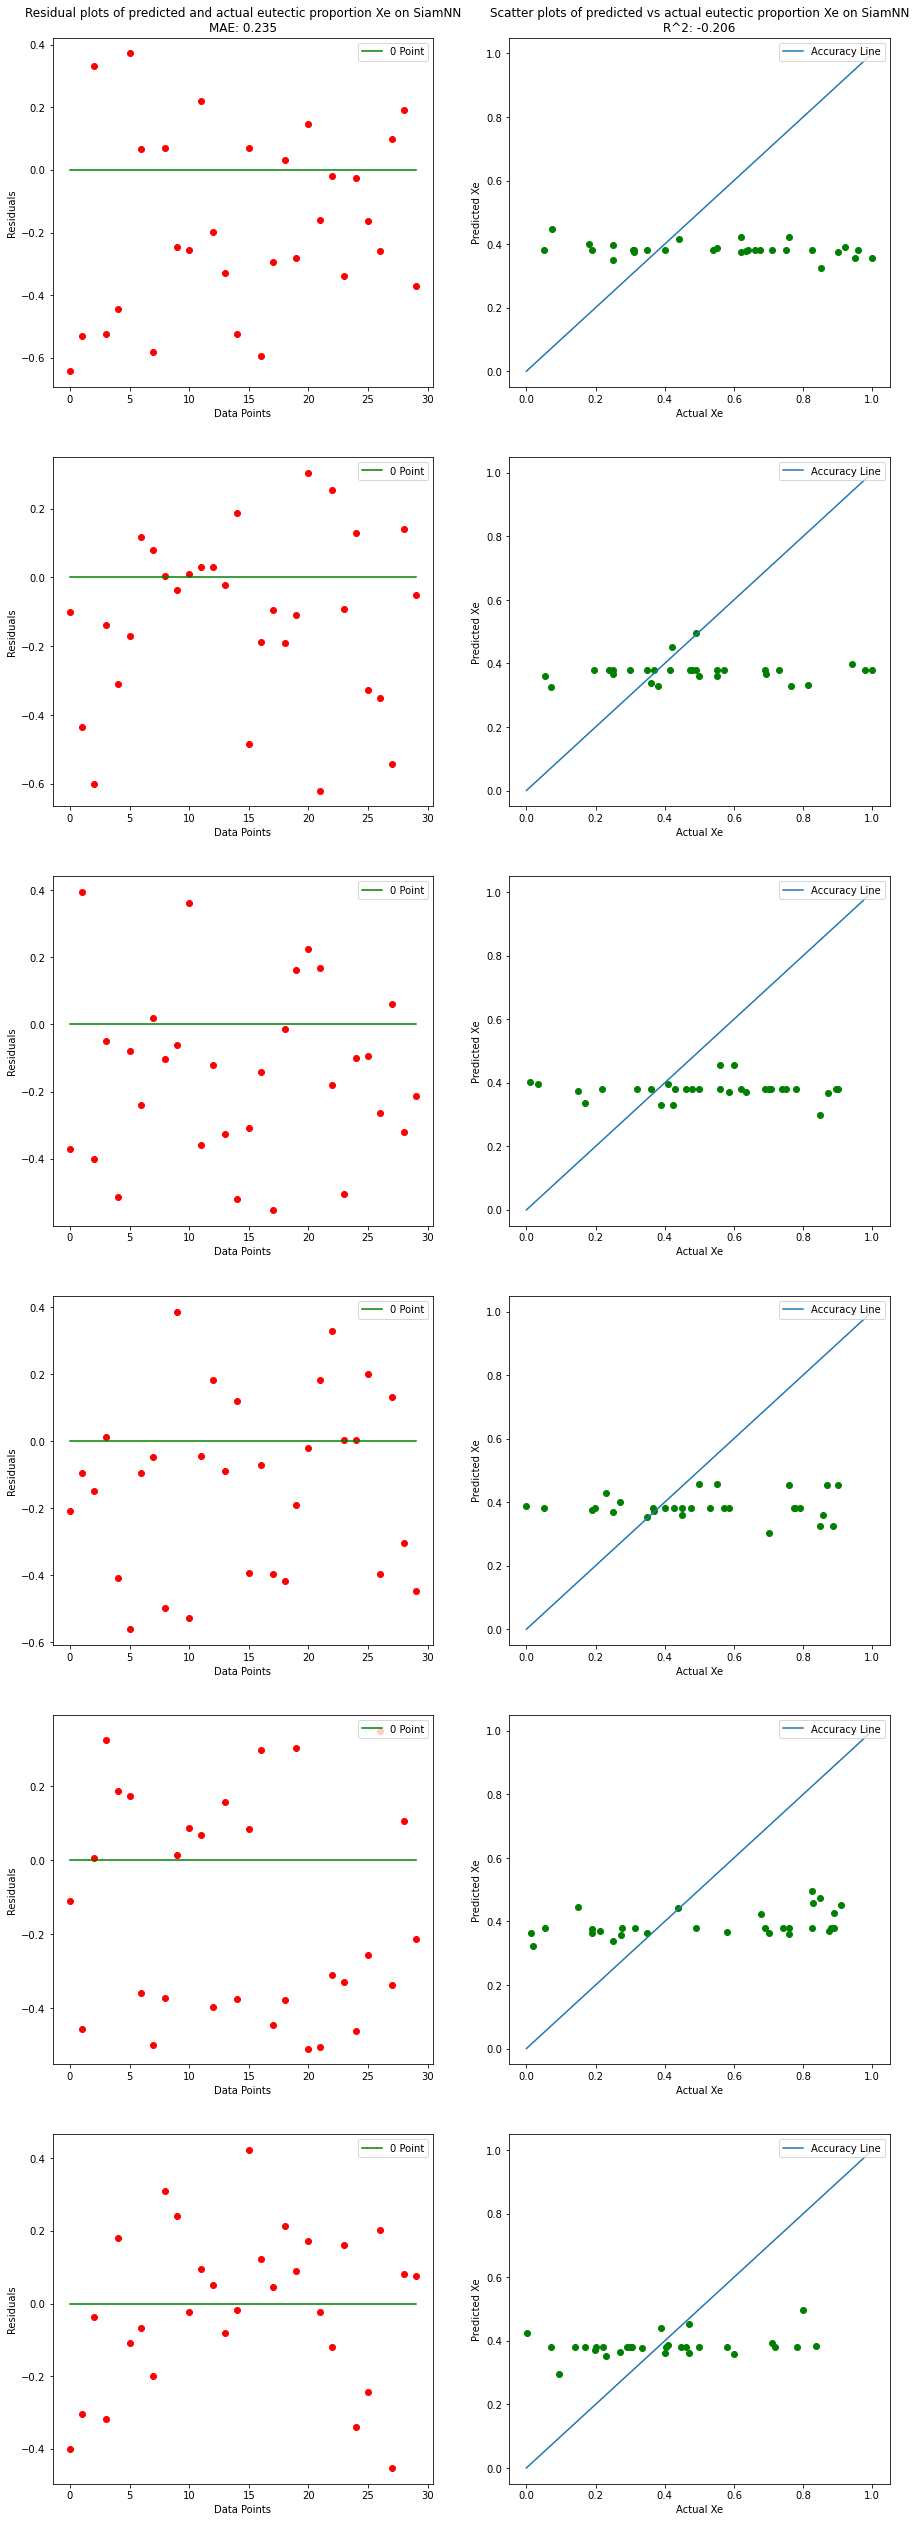

In [25]:
l = batchsize
numplots = int(len(simpoutputs) / l)
simpfig, axes = plt.subplots(numplots, 2)
simpfig.set_figheight(45)
simpfig.set_figwidth(15)

pred = 0
succ = 1
x = np.arange(l)
acc = np.linspace(0, 1, 10)
mae = np.round(simptestloss, 3)
r2 = 0
        
for row in range(numplots):        
    axes[row, 0].scatter(x, simpoutputs[pred*l:succ*l] - simptruths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(simptruths[pred*l:succ*l], simpoutputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(acc, acc, label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")
            
    pred += 1
    succ += 1

r2 = np.round(r2_score(simptruths, simpoutputs), 3)

if train_param == "xe":
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic proportion Xe on SiamNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic proportion Xe on SiamNN\nR^2: {}".format(r2))
else: 
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic temperature Te on SiamNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic temperature Te on SiamNN\nR^2: {}".format(r2))

plt.show()

In [26]:
# Print the values from the last batch processed just for the user to see
if train_param == "xe":
    disp = pd.DataFrame({
        'f(A,B) + f(B,A)': outputs + invouts,
        'Truth': np.round(truths, 3),
        'Siamese Pred': np.round(outputs, 3),
        'Simple Pred': np.round(simpoutputs, 3)
    })
else:
    disp = pd.DataFrame({
        'Truth': np.round(truths, 3),
        'Siamese Pred': np.round(outputs, 3), 
        'Simple Pred': np.round(simpoutputs, 3)
    })
        
disp.style.set_properties(**{'width': '150px'})

,"f(A,B) + f(B,A)",Truth,Siamese Pred,Simple Pred
0,1.000000,1.000000,0.436000,0.358000
1,1.000000,0.920000,0.498000,0.391000
2,1.000000,0.050000,0.502000,0.380000
3,1.000000,0.900000,0.559000,0.376000
4,1.000000,0.825000,0.501000,0.380000
5,1.000000,0.075000,0.494000,0.447000
6,1.000000,0.310000,0.559000,0.376000
7,1.000000,0.960000,0.497000,0.380000
8,1.000000,0.309000,0.582000,0.380000
9,1.000000,0.621000,0.425000,0.375000


In [27]:
# lossfig.savefig('D:\\Research\\UConn_ML\\Plots\\Lossplots_8_11_22.png')
# siamfig.savefig('D:\\Research\\UConn_ML\\Plots\\SiamNNplots_8_11_22.png')
# simpfig.savefig('D:\\Research\\UConn_ML\\Plots\\SimpNNplots_8_11_22.png')